In [1]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

/home/harveyaa/.local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


# **Model Selection**
In this tutorial we'll use a real dataset to demonstrate using cross-validation for model selection.

## **Cross-Validation**
In PyNM we've implemented cross-validation to help with model selection by giving a more stable estimate of the quality of the model fit. The training data is split into folds, training and test is done on each fold and model fit is evaluated, the model fit evaluation is an average of the metrics across folds, finally a model is fit on all the training data as usual.


## **Example**
In this example we'll use the Cobre dataset to demonstrate using cross-validation for model selection.

First, we'll use nilearn to fetch the data. Running the cell below will download ~700 MB of data to your machine.

In [2]:
# Download the dataset
cobre = datasets.fetch_cobre(n_subjects=None)

/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fetch_cobre is deprecated; 'fetch_cobre' has been deprecated and will be removed in release 0.9 . Please consider using a different datasets or downloading it with a different tool than nilearn.
  warnings.warn(msg, category=FutureWarning)
/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Now that we have our data, we will need to process it from functional scans (4D data) into connectomes for each subject.

In [3]:
# Download an atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

# Create the masker and correlation measure
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)
correlation_measure = ConnectivityMeasure(kind='correlation')

# Get a connectome for each subject
connectomes=[]
for func,conf in zip(np.sort(cobre.func),np.sort(cobre.confounds)):
    ts = masker.fit_transform(func, confounds=conf)
    corr = correlation_measure.fit_transform([ts])[0]
    connectomes.append(corr)

connectomes = np.array(connectomes)

Now we'll build a dataframe that we can use with PyNM. We'll grab the IDs, status (patient or control), gender, and age from the Cobre phenotypic information first and sort the values according to ID to match the order we processed the connectomes. Then we'll choose a random edge of the connectome to model for our example and add it to the dataframe.

In [4]:
# Create a dataframe
pheno = pd.DataFrame([int(x) for x in cobre.phenotypic['id']])
pheno['status'] = [(x==b'Patient')*1 for x in cobre.phenotypic['subject_type']]
pheno['gender'] = [(x==b'Female')*1 for x in cobre.phenotypic['gender']]
pheno['age'] = [x for x in cobre.phenotypic['current_age']]

# Sort the values by id (same sorting as above)
pheno.sort_values(0,inplace=True)

# Add the response variable to the dataframe
pheno['edge'] = connectomes[:,5,8]

### Visualize data

<AxesSubplot:xlabel='age', ylabel='edge'>

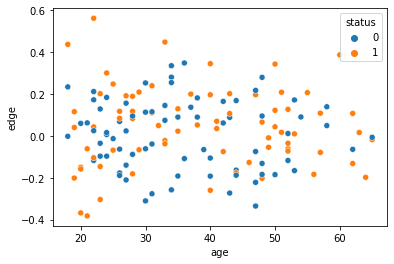

In [5]:
sns.scatterplot(x='age',y='edge',data=pheno,hue='status')

### Fit Normative Models
Here we'll run each model seperately so we can see the output of the cross-validation at each fold.

In [6]:
# Initialize pynm w/ data, confounds & bin parameters
m = PyNM(pheno,'edge','status',['age','c(gender)'],bin_width=15,bin_spacing=1)

Models will be fit on full set of controls.


In [7]:
# Run Centiles model
m.centiles_normative_model(cv_folds=5)

Starting 5 folds of CV...
CV Fold 0: RMSE=0.186 - SMSE=1.172
CV Fold 1: RMSE=0.188 - SMSE=1.049
CV Fold 2: RMSE=0.167 - SMSE=1.093
CV Fold 3: RMSE=0.181 - SMSE=1.296
CV Fold 4: RMSE=0.200 - SMSE=1.417
Done!
Average: RMSE=0.185 - SMSE=1.205


In [8]:
# Run LOESS model
m.loess_normative_model(cv_folds=5)

Starting 5 folds of CV...
CV Fold 0: RMSE=0.138 - SMSE=1.023
CV Fold 1: RMSE=0.149 - SMSE=1.007
CV Fold 2: RMSE=0.177 - SMSE=1.007
CV Fold 3: RMSE=0.221 - SMSE=1.089
CV Fold 4: RMSE=0.151 - SMSE=1.006
Done!
Average: RMSE=0.167 - SMSE=1.027


In [9]:
# Run GP model
m.gp_normative_model(cv_folds=5)

Starting 5 folds of CV...
CV Fold 0: RMSE=0.175 - SMSE=1.007 - MSLL=-0.407
CV Fold 1: RMSE=0.172 - SMSE=1.034 - MSLL=-0.426


/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  

CV Fold 2: RMSE=0.142 - SMSE=1.048 - MSLL=-0.566
CV Fold 3: RMSE=0.193 - SMSE=1.000 - MSLL=-0.277
CV Fold 4: RMSE=0.150 - SMSE=1.267 - MSLL=-0.522
Done!
Average: RMSE=0.166 - SMSE=1.071 - MSLL=-0.440


/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  Con

In [10]:
# Run GAMLSS model
m.gamlss_normative_model(cv_folds=5)

/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Starting 5 folds of CV...
GAMLSS-RS iteration 1: Global Deviance = -23.9391 
GAMLSS-RS iteration 2: Global Deviance = -31.249 
GAMLSS-RS iteration 3: Global Deviance = -36.7788 
GAMLSS-RS iteration 4: Global Deviance = -42.7186 
GAMLSS-RS iteration 5: Global Deviance = -47.7354 
GAMLSS-RS iteration 6: Global Deviance = -51.0967 
GAMLSS-RS iteration 7: Global Deviance = -53.3785 
GAMLSS-RS iteration 8: Global Deviance = -54.9744 
GAMLSS-RS iteration 9: Global Deviance = -56.0461 
GAMLSS-RS iteration 10: Global Deviance = -56.547 
GAMLSS-RS iteration 11: Global Deviance = 5646.114 
GAMLSS-RS iteration 12: Global Deviance = 5121.977 
GAMLSS-RS iteration 13: Global Deviance = 4610.305 
GAMLSS-RS iteration 14: Global Deviance = 4120.176 
GAMLSS-RS iteration 15: Global Deviance = 3678.041 
GAMLSS-RS iteration 16: Global Deviance = 3267.567 
GAMLSS-RS iteration 17: Global Deviance = 2858.354 
GAMLSS-RS iteration 18: Global Deviance = 2448.576 
GAMLSS-RS iteration 19: Global Deviance = 2038.41

### Visualize Models

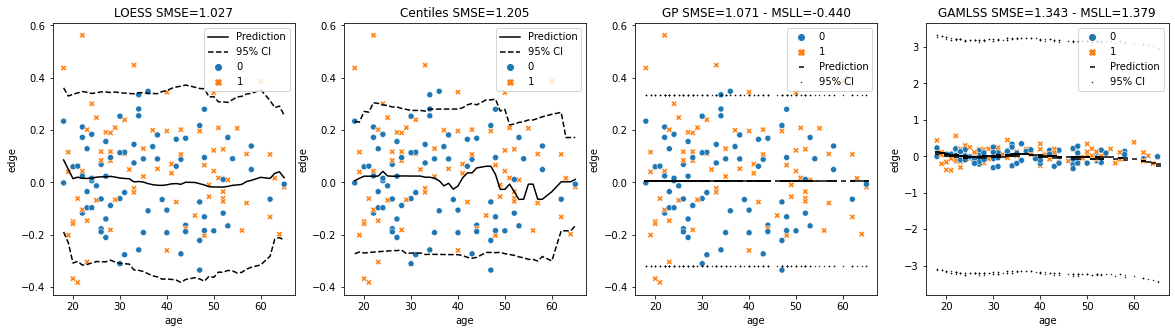

In [13]:
m.plot()

In [12]:
print(f"""SMSE
Centiles {m.SMSE_Centiles:.4f}
LOESS    {m.SMSE_LOESS:.4f}
GP       {m.SMSE_GP:.4f}
GAMLSS   {m.SMSE_GAMLSS:.4f}
""")

print(f"""RMSE
Centiles {m.RMSE_Centiles:.4f}
LOESS    {m.RMSE_LOESS:.4f}
GP       {m.RMSE_GP:.4f}
GAMLSS   {m.RMSE_GAMLSS:.4f}
""")

print(f"""MSLL
GP       {m.MSLL_GP:.4f}
GAMLSS   {m.MSLL_GAMLSS:.4f}
""")


SMSE
Centiles 1.2052
LOESS    1.0266
GP       1.0713
GAMLSS   1.3427

RMSE
Centiles 0.1845
LOESS    0.1672
GP       0.1663
GAMLSS   0.2120

MSLL
GP       -0.4395
GAMLSS   1.3788



## **Summary**

## **Resources**